In [ ]:
!pip install pyradiomics==3.0.1;
!pip install SimpleITK==2.2.1;
!pip install lifelines

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tools import add_constant
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, chi2,f_classif,mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import os
import nibabel as nib
from pathlib import Path
from radiomics import featureextractor,firstorder
import SimpleITK as sitk
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter,CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
import scipy.stats as stats

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
path = "/content/gdrive/MyDrive/Dataset/QIN-LUAD-CT-SURVIVAL_NIFTI/"
ListofPX = os.listdir(path)

px_path = path + ListofPX[0]
files = os.listdir(px_path)

labels_path = path + "FeaturesWithMonths.csv"

dfLabels = pd.read_csv(labels_path)
dfLabels.head()

,patient_id,event,duration,Label,Longest.Diameter..mm.,Short.Axis...Longest.Diameter..mm..,Short.Axis..mm.,Mean..HU.,StdDev..HU.,Volume..cm..,...,X3D.Wavelet.decomposition...P1.L2.C3.Layer.1,X3D.Wavelet.decomposition...P1.L2.C4.Layer.1,X3D.Wavelet.decomposition...P1.L2.C5.Layer.1,X3D.Wavelet.decomposition...P1.L2.C6.Layer.1,X3D.Wavelet.decomposition...P1.L2.C7.Layer.1,X3D.Wavelet.decomposition...P1.L2.C8.Layer.1,Convexity_Mean,Conv_Area_Perim,IsAttached,Std_Conv
0,R0004,1,2010,1,45.50,1520.73,33.42,-20.13,136.80,33.06,...,922.503735,7055.561581,25833.098760,8449.116111,737.184747,6172.425054,0.863500,0.642984,0.863500,0.097923
1,R0013,1,1374,1,41.82,617.67,14.77,-9.56,119.63,14.78,...,717.342696,4189.960074,15237.079170,4561.750068,613.539088,3699.644891,0.845099,0.866819,0.807820,0.027609
2,R0017,1,2066,1,18.95,240.46,12.69,-73.58,151.36,1.76,...,11.057679,15.946198,1585.785644,2164.498445,59.819492,491.460387,0.931435,0.918455,0.931435,0.013920
3,R0018,1,494,0,35.04,1086.57,31.01,28.45,93.49,16.85,...,494.811919,3947.601380,12430.672920,3005.110061,400.538246,3257.483750,0.917999,0.897987,0.917999,0.025730
4,R0019,1,323,0,31.87,613.64,19.25,-30.00,146.40,10.97,...,89.742340,571.684059,8299.075649,2753.117372,89.089983,381.985943,0.931737,0.946039,0.860215,0.039337


In [5]:
#Split in training and test and stratify
train_data, test_data = train_test_split(dfLabels, test_size=0.2, random_state=42, stratify=dfLabels['Label'])

Extract Radiomics

In [6]:
train_data_features = train_data.drop(columns=['event'])
train_data_features = train_data_features.drop(columns=['duration'])
train_data_features = train_data_features.drop(columns=['Label'])
train_data_features.head()

,patient_id,Longest.Diameter..mm.,Short.Axis...Longest.Diameter..mm..,Short.Axis..mm.,Mean..HU.,StdDev..HU.,Volume..cm..,X5a_3D_MacSpic_NumberOf,X8a_3D_Is_Attached_To_Pleural_Wall,X8b_3D_Relative_Border_To_Lung,...,X3D.Wavelet.decomposition...P1.L2.C3.Layer.1,X3D.Wavelet.decomposition...P1.L2.C4.Layer.1,X3D.Wavelet.decomposition...P1.L2.C5.Layer.1,X3D.Wavelet.decomposition...P1.L2.C6.Layer.1,X3D.Wavelet.decomposition...P1.L2.C7.Layer.1,X3D.Wavelet.decomposition...P1.L2.C8.Layer.1,Convexity_Mean,Conv_Area_Perim,IsAttached,Std_Conv
20,R0108,22.04,334.02,15.16,-74.42,143.38,3.50,0,1,0.993387,...,15.116152,13.340741,2923.134456,838.047522,506.693101,1556.594034,0.939503,0.934924,0.939503,0.024912
39,R0274,8.52,56.52,6.63,-117.11,125.84,0.42,0,0,1.000000,...,4.252681,9.036845,221.963186,77.412551,4.510009,8.077625,0.960938,0.960938,0.960938,0.000000
14,R0079,24.15,334.15,13.84,-44.61,132.36,3.19,0,1,0.944443,...,20.549603,22.802624,2570.658230,778.721099,22.157028,291.037540,0.958208,0.954436,0.958208,0.040040
24,R0144,56.20,2170.02,38.61,-83.90,185.12,67.55,0,1,0.724226,...,72.400769,117.335990,30037.815210,3883.649278,66.169465,199.466437,0.956754,0.946422,0.956754,0.023863
26,R0150,17.65,246.74,13.98,-153.20,165.58,2.50,0,0,1.000000,...,8.053979,10.003617,3002.644284,1821.501355,256.828407,51.114564,0.883746,0.938224,0.883746,0.077043


In [7]:
# @title

def extract_radiomics_features(image_path, mask_path, settings=None,binWidth=25,label=1,typesRadiomicsToExtract=['firstorder','shape','glcm','glrlm','glszm','ngtdm','gldm']):
    default_settings = {'binWidth': binWidth, 'resampledPixelSpacing': [1, 1, 1],
                        'interpolator': sitk.sitkLinear, 'enableCExtensions': True,
                        'normalize': False, 'geometryTolerance': None}
    if settings: default_settings.update(settings)
    try:
        extractor = featureextractor.RadiomicsFeatureExtractor(**default_settings)
        for cls in typesRadiomicsToExtract:
            extractor.enableFeatureClassByName(cls)
        feature_dict = extractor.execute(image_path, mask_path, label)
        return feature_dict
    except Exception as e:
        print(f"Feature extraction failed: {e}")
        return {}

def define_discretization_strategy(bin_method='fixed_bin_width', bin_width=25, bin_count=None):
    settings = {}
    if bin_method == 'fixed_bin_width':
        settings['binWidth'] = bin_width
    elif bin_method == 'fixed_bin_count':
        settings['binCount'] = bin_count
    else:
        raise ValueError("Method must be 'fixed_bin_width' or 'fixed_bin_count'")
    return settings

def save_radiomics_to_dataframe(feature_dict_list, patient_ids, output_path=None):
    df = pd.DataFrame(feature_dict_list, index=patient_ids)
    df.insert(0, 'patient_id', patient_ids)
    features = [c for c in df.columns if c != 'patient_id']
    features.sort()
    df = df[['patient_id'] + features]
    return df

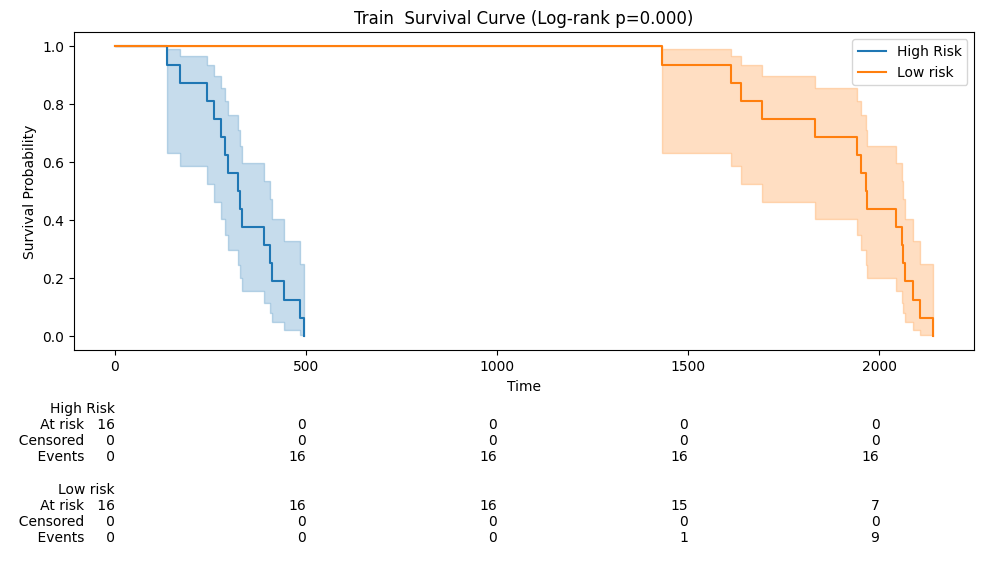

In [20]:
def plot_kaplan_meier(survival_data, group_col, title="Kaplan-Meier Curve",names=None):
    kmf = KaplanMeierFitter()

    groups = survival_data[group_col].unique()
    fig, ax = plt.subplots(figsize=(10, 6))
    kmfs = []

    if len(groups) > 1:
        group1_data = survival_data[survival_data[group_col] == groups[0]]
        group2_data = survival_data[survival_data[group_col] == groups[1]]
        results = logrank_test(group1_data['duration'], group2_data['duration'],
                                event_observed_A=group1_data['event'],
                                event_observed_B=group2_data['event'])
        p_value = results.p_value
        title += f" (Log-rank p={p_value:.3f})"

    for name, group_data in survival_data.groupby(group_col):
        kmf = KaplanMeierFitter()
        if name ==1 : name = "Low risk"
        if name ==0 : name = "High Risk"
        kmf.fit(group_data['duration'], event_observed=group_data['event'], label=name)
        kmf.plot_survival_function(ax=ax)
        kmfs.append(kmf)

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    add_at_risk_counts(*kmfs, ax=ax)
    plt.tight_layout()
    plt.show()

plot_kaplan_meier(train_data,group_col = "Label" ,title="Train  Survival Curve")

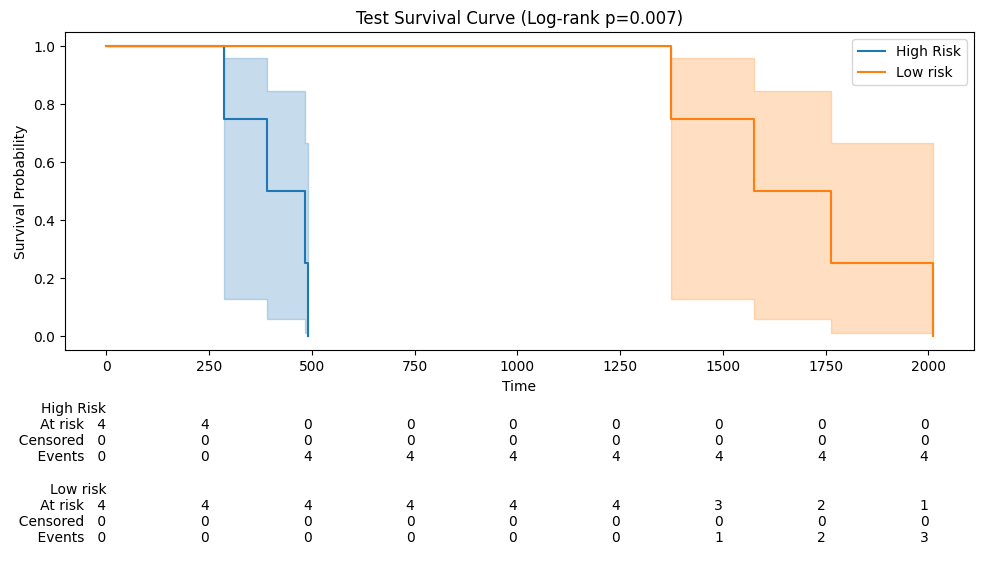

In [21]:
plot_kaplan_meier(test_data,group_col = "Label" ,title="Test Survival Curve")

In [9]:
def clean_radiomics_features(df_features, remove_constant=True, remove_missing=True, missing_threshold=0.1, constant_threshold=1e-6):
    df_clean = df_features.copy()
    report = {'original_features': len(df_features.columns)-1, 'removed_features': {}, 'final_features': 0}
    feature_cols = [col for col in df_clean.columns if col != 'patient_id']
    if remove_missing:
        missing_ratios = df_clean[feature_cols].isnull().sum() / len(df_clean)
        high_missing = missing_ratios[missing_ratios > missing_threshold].index.tolist()
        if high_missing:
            df_clean = df_clean.drop(columns=high_missing)
            report['removed_features']['high_missing'] = high_missing
    if remove_constant:
        feature_cols = [col for col in df_clean.columns if col != 'patient_id']
        constant_features = [col for col in feature_cols if df_clean[col].dropna().std() < constant_threshold]
        if constant_features:
            df_clean = df_clean.drop(columns=constant_features)
            report['removed_features']['constant'] = constant_features
    feature_cols = [col for col in df_clean.columns if col != 'patient_id']
    invalid_features = [col for col in feature_cols if df_clean[col].isin([np.inf, -np.inf]).any()]
    if invalid_features:
        df_clean = df_clean.drop(columns=invalid_features)
        report['removed_features']['invalid'] = invalid_features
    report['final_features'] = len(df_clean.columns)-1
    return df_clean, report


def remove_correlated_features(df_features, threshold=0.9):
    feature_cols = [col for col in df_features.columns if col != 'patient_id']

    # Calculate correlation matrix
    corr_matrix = df_features[feature_cols].corr().abs()

    # Find pairs with correlation above threshold
    upper_tri = corr_matrix.where(
        np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    )

    # Find features to drop
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    print(f"Removing {len(to_drop)} highly correlated features (r > {threshold})")

    # Return cleaned dataframe
    cleaned_features = [col for col in feature_cols if col not in to_drop]
    df_cleaned = df_features[['patient_id'] + cleaned_features]

    return df_cleaned, to_drop

survival_data = train_data[['patient_id', 'duration', 'event']]
train_clean,report = clean_radiomics_features(train_data_features, remove_constant=True, remove_missing=True, missing_threshold=0.1, constant_threshold=1e-2)
train_clean, to_drop = remove_correlated_features(train_clean, threshold=0.7)
train_clean.head()

Removing 115 highly correlated features (r > 0.7)


,patient_id,Longest.Diameter..mm.,Mean..HU.,StdDev..HU.,X5a_3D_MacSpic_NumberOf,X8a_3D_Is_Attached_To_Pleural_Wall,X8b_3D_Relative_Border_To_Lung,X9a_3D_FractionalAnisotropy,X9b_3D_Circularity,X10d_3D_SD_Volume_AirSpaces_.mm..,Density,Radius.of.largest.enclosed.ellipse,avgHGRE,X3D.Laws.features..E5.E5.E5.Layer.1,X3D.Laws.features..E5.E5.L5.Layer.1,X3D.Wavelet.decomposition...P1.L2.C9.Layer.1,X3D.Wavelet.decomposition...P1.L2.C7.Layer.1,Conv_Area_Perim,IsAttached,Std_Conv
20,R0108,22.04,-74.42,143.38,0,1,0.993387,0.184204,0.690041,4.714045,1.077164,0.076162,40100.19225,0.021722,0.166326,292.666210,506.693101,0.934924,0.939503,0.024912
39,R0274,8.52,-117.11,125.84,0,0,1.000000,0.181505,0.220765,0.000000,1.025399,0.395468,29926.45547,0.008489,0.168313,399.710464,4.510009,0.960938,0.960938,0.000000
14,R0079,24.15,-44.61,132.36,0,1,0.944443,0.259113,0.663729,0.000000,1.053435,0.103608,39098.42167,0.038376,0.098839,305.248882,22.157028,0.954436,0.958208,0.040040
24,R0144,56.20,-83.90,185.12,0,1,0.724226,0.197686,0.453584,1485.605250,1.141563,0.038288,23065.17159,0.012835,0.030732,1063.940002,66.169465,0.946422,0.956754,0.023863
26,R0150,17.65,-153.20,165.58,0,0,1.000000,0.176361,0.605449,15.000000,1.127180,0.050367,26423.21179,0.030951,0.160962,394.276654,256.828407,0.938224,0.883746,0.077043


In [10]:
def univariate_feature_screening(df_features, survival_data, method='cox', alpha=0.05):
    """
    Perform univariate screening of features for survival analysis.

    Parameters:
    -----------
    df_features : pd.DataFrame
        DataFrame with radiomics features
    survival_data : pd.DataFrame
        DataFrame with columns ['patient_id', 'duration', 'event']
    method : str
        Method for univariate screening ('cox', 'correlation', 'f_test')
    alpha : float
        Significance level for p-value filtering

    Returns:
    --------
    pd.DataFrame : Results of univariate screening sorted by p-value
    """

    # Merge features with survival data
    merged_data = survival_data.merge(df_features, on='patient_id')
    feature_cols = [col for col in df_features.columns if col != 'patient_id']

    results = []

    for feature in feature_cols:
        result = {'feature': feature}

        # Get valid data (remove missing values)
        valid_mask = ~merged_data[feature].isnull()
        feature_values = merged_data.loc[valid_mask, feature]
        durations = merged_data.loc[valid_mask, 'duration']
        events = merged_data.loc[valid_mask, 'event']

        if len(feature_values) < 5:  # Skip features with too few valid values
            result.update({'p_value': 1.0, 'statistic': 0, 'valid_n': len(feature_values)})
        else:
            try:
                if method == 'cox':
                    # Fit univariate Cox model
                    cox_data = pd.DataFrame({
                        'duration': durations,
                        'event': events,
                        'feature': feature_values
                    })

                    cph = CoxPHFitter(penalizer=0.01)  # Small penalizer for stability
                    cph.fit(cox_data, duration_col='duration', event_col='event')

                    result.update({
                        'p_value': cph.summary['p'].iloc[0],
                        'hazard_ratio': cph.summary['exp(coef)'].iloc,
                        'coef': cph.summary['coef'].iloc,
                        'ci_lower': cph.summary['exp(coef) lower 95%'].iloc,
                        'ci_upper': cph.summary['exp(coef) upper 95%'].iloc,
                        'valid_n': len(feature_values)
                    })

            except Exception as e:
                print(f"Error processing feature {feature}: {e}")
                result.update({'p_value': 1.0, 'error': str(e), 'valid_n': len(feature_values)})

        results.append(result)

    # Convert to DataFrame and sort by p-value
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('p_value')

    # Add significance flag
    results_df['significant'] = results_df['p_value'] < alpha

    print(f"Univariate screening completed:")
    print(f"  Method: {method}")
    print(f"  Significant features (p < {alpha}): {sum(results_df['significant'])}")
    print(f"  Total features tested: {len(results_df)}")


    significant_features = results_df[results_df['significant'] == True]
    print(f"Significant features are:\n{significant_features[['feature','p_value']]}")


    return results_df,significant_features

results_df,significant_features = univariate_feature_screening(train_clean, survival_data, method='cox', alpha=0.07)
feature_name = significant_features['feature']

Univariate screening completed:
  Method: cox
  Significant features (p < 0.07): 6
  Total features tested: 19
Significant features are:
                                         feature   p_value
5                 X8b_3D_Relative_Border_To_Lung  0.001040
14  X3D.Wavelet.decomposition...P1.L2.C9.Layer.1  0.016537
8              X10d_3D_SD_Volume_AirSpaces_.mm..  0.031978
17                                    IsAttached  0.032340
7                             X9b_3D_Circularity  0.033951
4             X8a_3D_Is_Attached_To_Pleural_Wall  0.042595


In [11]:
def cross_validate_cox_model(df_features, survival_data, feature_names=None, cv_folds=5, penalizer=0.0):
    merged_data = survival_data.merge(df_features, on='patient_id')
    feature_cols = feature_names or [col for col in df_features.columns if col != 'patient_id']
    full_data = merged_data[['duration', 'event'] + feature_cols].dropna()

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    c_indices, log_likelihoods = [], []

    for train_idx, test_idx in cv.split(full_data, full_data['event']):
        train = full_data.iloc[train_idx].copy()
        test = full_data.iloc[test_idx].copy()

        scaler = StandardScaler()


        train[feature_cols] = pd.DataFrame(scaler.fit_transform(train[feature_cols]),columns=feature_cols,index=train.index).astype(float)
        test[feature_cols] = pd.DataFrame(scaler.transform(test[feature_cols]),columns=feature_cols,index=test.index).astype(float)

        cph = CoxPHFitter(penalizer=penalizer)
        cph.fit(train, duration_col='duration', event_col='event')

        preds = cph.predict_partial_hazard(test)
        c_index = concordance_index(test['duration'], -preds, test['event'])
        c_indices.append(c_index)
        log_likelihoods.append(cph.log_likelihood_)

    return {
        "c_indices": c_indices,
        "mean_c_index": np.mean(c_indices),
        "std_c_index": np.std(c_indices)
    }


dictmetrics = cross_validate_cox_model(train_clean, survival_data, feature_names=feature_name.tolist(), cv_folds=5, penalizer=0.1)

print("C_indices", dictmetrics['c_indices'])
print("Mean C index", dictmetrics['mean_c_index'])
print("Std c Index", dictmetrics['std_c_index'])

C_indices [np.float64(0.5238095238095238), np.float64(0.7619047619047619), np.float64(0.9333333333333333), np.float64(0.7333333333333333), np.float64(0.4666666666666667)]
Mean C index 0.6838095238095239
Std c Index 0.16944888660026075


In [12]:
def fit_cox_regression(df_features, survival_data, feature_names=None, penalizer=0.0):
    merged_data = survival_data.merge(df_features, on='patient_id')
    feature_cols = feature_names or [col for col in df_features.columns if col != 'patient_id']
    data = merged_data[['duration', 'event'] + feature_cols].dropna()
    scaler = StandardScaler()
    data[feature_cols] = scaler.fit_transform(data[feature_cols])
    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(data, duration_col='duration', event_col='event')
    summary = {
        'n_samples': len(data),
        'n_features': len(feature_cols),
        'concordance_index': cph.concordance_index_,
        'feature_coefficients': dict(zip(feature_cols, cph.params_)),
        'scaler': scaler
    }
    return cph, summary

cph, summary = fit_cox_regression(train_clean, survival_data, feature_names=feature_name.tolist(), penalizer=0.1)
summary

{'n_samples': 32,
 'n_features': 6,
 'concordance_index': np.float64(0.7056451612903226),
 'feature_coefficients': {'X8b_3D_Relative_Border_To_Lung': -0.5806009464449408,
  'X3D.Wavelet.decomposition...P1.L2.C9.Layer.1': 0.19915875978853317,
  'X10d_3D_SD_Volume_AirSpaces_.mm..': 0.5923480089194809,
  'IsAttached': -0.15719612548684503,
  'X9b_3D_Circularity': 0.16677208345328598,
  'X8a_3D_Is_Attached_To_Pleural_Wall': -0.0018483855833636496},
 'scaler': StandardScaler()}

In [13]:
def evaluate_cox_model(fitted_model, test_data, feature_names, scaler=None):
    test_prepared = test_data[['duration', 'event'] + feature_names].dropna()
    if scaler is not None:
        test_prepared[feature_names] = scaler.transform(test_prepared[feature_names])
    partial_hazards = fitted_model.predict_partial_hazard(test_prepared)
    c_index = concordance_index(test_prepared['duration'], -partial_hazards, test_prepared['event'])
    return {'concordance_index': c_index, 'feature_importance': dict(zip(feature_names, abs(fitted_model.params_)))}

evaluate_cox_model(cph, test_data, feature_name.tolist(), scaler=None)


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


{'concordance_index': np.float64(0.5714285714285714),
 'feature_importance': {'X8b_3D_Relative_Border_To_Lung': 0.5806009464449408,
  'X3D.Wavelet.decomposition...P1.L2.C9.Layer.1': 0.19915875978853317,
  'X10d_3D_SD_Volume_AirSpaces_.mm..': 0.5923480089194809,
  'IsAttached': 0.15719612548684503,
  'X9b_3D_Circularity': 0.16677208345328598,
  'X8a_3D_Is_Attached_To_Pleural_Wall': 0.0018483855833636496}}

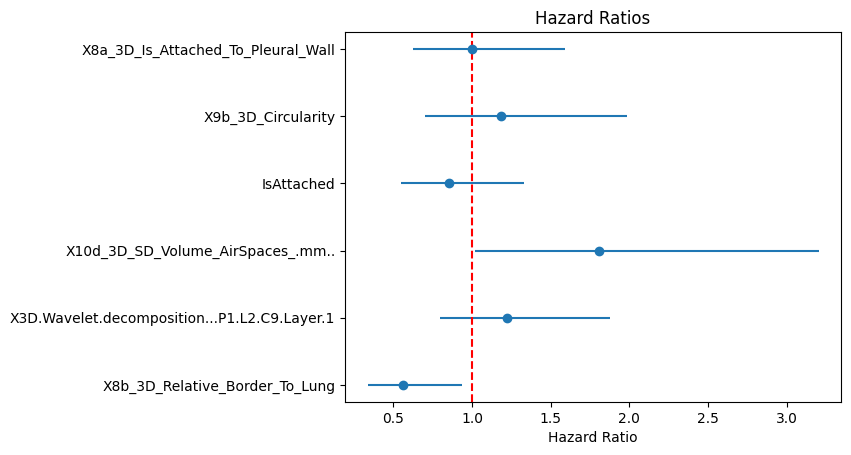

In [14]:
def plot_hazard_ratios(fitted_model, feature_names):
    summary = fitted_model.summary
    hr = summary['exp(coef)']
    plt.errorbar(hr, range(len(hr)), xerr=[hr-summary['exp(coef) lower 95%'], summary['exp(coef) upper 95%']-hr], fmt='o')
    plt.yticks(range(len(hr)), feature_names)
    plt.axvline(1, color='red', linestyle='--')
    plt.xlabel('Hazard Ratio')
    plt.title('Hazard Ratios')
    plt.show()

plot_hazard_ratios(cph, feature_name)